<a href="https://colab.research.google.com/github/deckboy/NLP/blob/main/Fine_Tuning_BERT_for_Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning BERT in Python for Disaster Tweets Classification

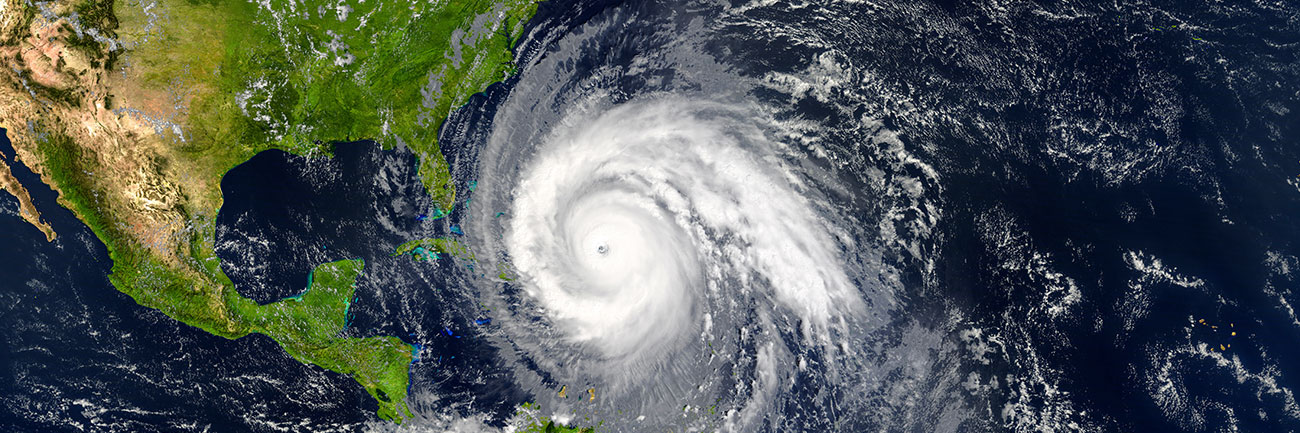

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

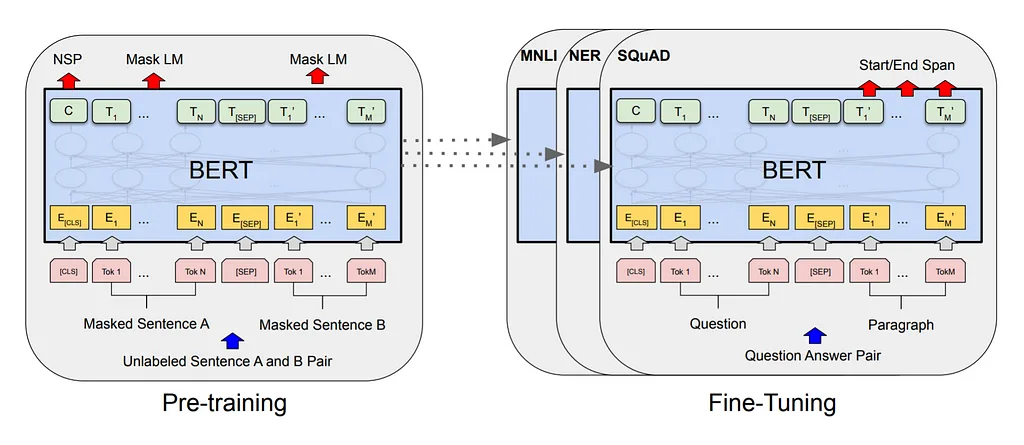

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Real or Not? Disaster Tweets Classifications

In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [2]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [47]:
tweet.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [48]:
tweet.shape

(7613, 5)

In [49]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [50]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

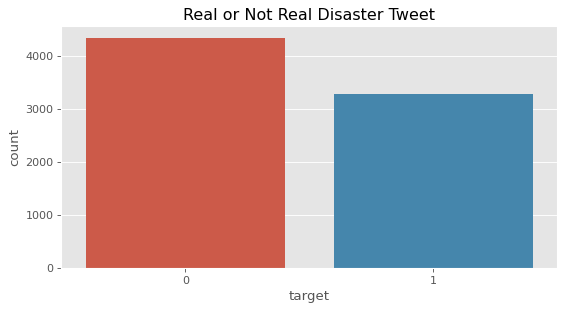

In [51]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [52]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

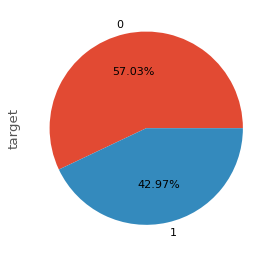

In [53]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [54]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-vmmhta15
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-vmmhta15
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11759 sha256=6e3c40622d4ff66061a6cba9e6253e52a984309df85692d90b398ccfc12f164e
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfro_4km/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [7]:
import preprocess_kgptalkie as kgp

In [8]:
tweet = kgp.get_basic_features(tweet)

In [9]:
tweet.head()

id keyword location  ... mentions_counts  digits_counts  uppercase_counts
0   1     NaN      NaN  ...               0              0                 1
1   4     NaN      NaN  ...               0              1                 0
2   5     NaN      NaN  ...               0              1                 0
3   6     NaN      NaN  ...               0              1                 0
4   7     NaN      NaN  ...               0              0                 0

[5 rows x 13 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


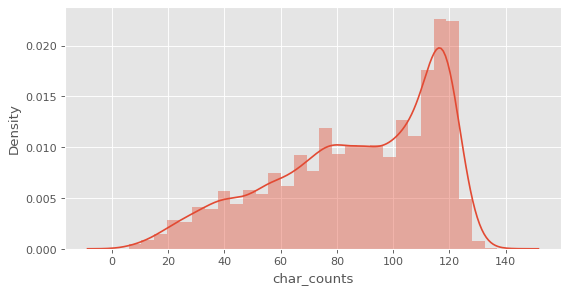

In [58]:
sns.distplot(tweet['char_counts'])

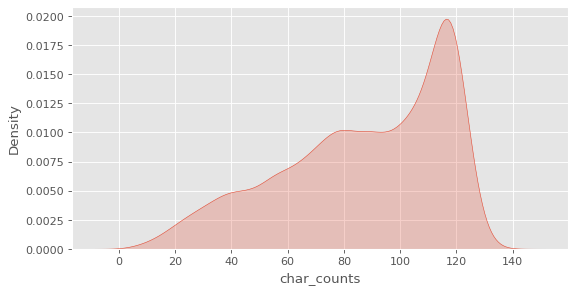

In [59]:
sns.kdeplot(tweet['char_counts'], shade=True)

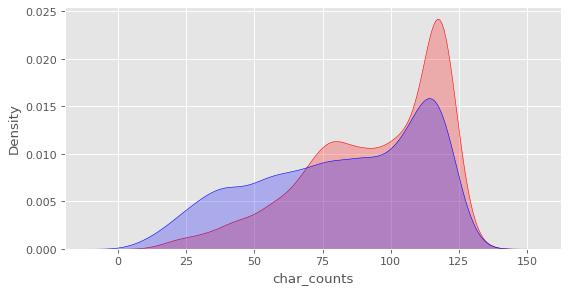

In [60]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

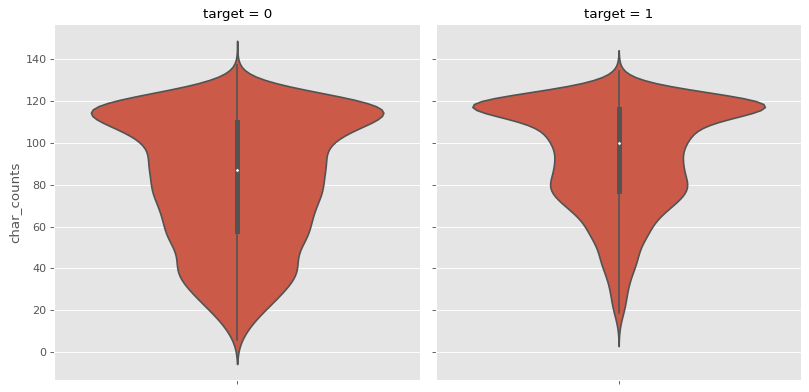

In [61]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

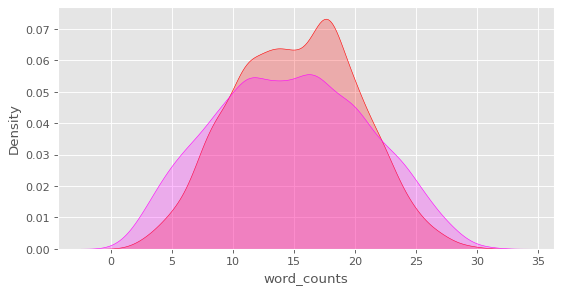

In [62]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


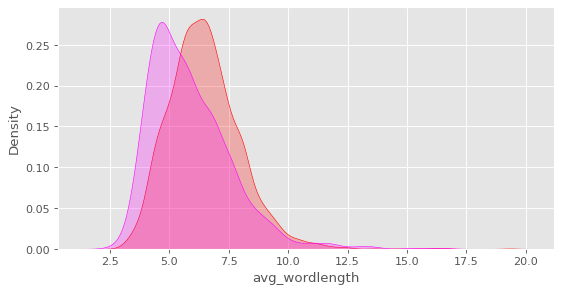

In [63]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


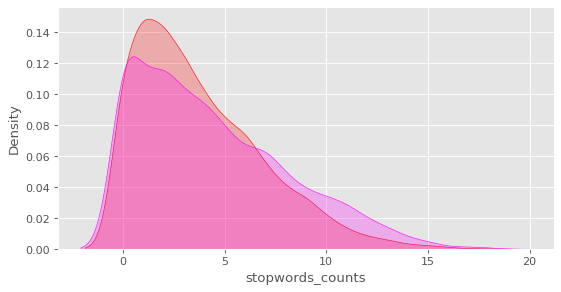

In [64]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [65]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [66]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [67]:
top20 = freqs[100:120]

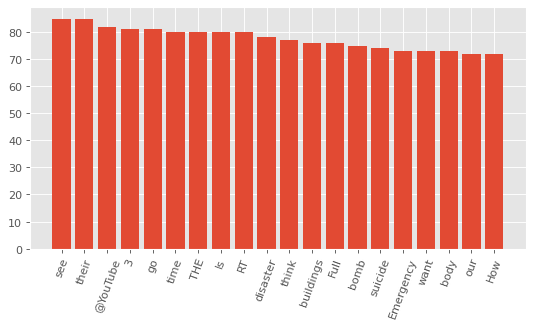

In [68]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [69]:
least20 = freqs[-20:]
least20

#Bluebell                 1
killings                  1
@Kaotix_Blaze             1
Reach                     1
'#Tory                    1
#triciaoneill             1
Twain                     1
http://t.co/tdeQwm8ZXn    1
#GravityMovie             1
@hanna_brooksie           1
ouch                      1
You.                      1
unbelievably              1
#sydtraffic               1
risks.                    1
#pugprobs                 1
http://t.co/unNx71v8qc    1
change's                  1
#Niagara.Vehicles         1
Our_Mother_Mary:          1
dtype: int64

In [70]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [71]:
bigram[100:120]

[('ûï emergency', 68395),
 ('ûï dylanmcclure55', 68394),
 ('ûï bbcwomanshour', 68393),
 ('ûï bbcengland', 68392),
 ('ûï based_georgie', 68391),
 ('ûï _keits', 68390),
 ('ûªve seen', 68389),
 ('ûªve just', 68388),
 ('ûªve ever', 68387),
 ('ûªve been', 68386),
 ('ûªt watch', 68385),
 ('ûªt warned', 68384),
 ('ûªt want', 68383),
 ('ûªt wanna', 68382),
 ('ûªt wait', 68381),
 ('ûªt say', 68380),
 ('ûªt research', 68379),
 ('ûªt let', 68378),
 ('ûªt know', 68377),
 ('ûªt govern', 68376)]

In [72]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

### One-Shot Data Cleaning

In [5]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x) # contraction expension
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x) # remove re-tweet
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [4]:
tweet['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [10]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [76]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [77]:
kgp.get_ngram(tweet, 'text', ngram_range=2)

[('zxathetis are', 67861),
 ('zurich for', 67860),
 ('zumiez is', 67859),
 ('zss vs', 67858),
 ('zourryart forgot', 67857),
 ('zouma just', 67856),
 ('zouma has', 67855),
 ('zotar50 skeleton', 67854),
 ('zoom in', 67853),
 ('zonewolf123 liked', 67852),
 ('zonesthank god', 67851),
 ('zones donuat', 67850),
 ('zone with', 67849),
 ('zone what', 67848),
 ('zone war', 67847),
 ('zone they', 67846),
 ('zone protectdenaliwolves', 67845),
 ('zone outside', 67844),
 ('zone of', 67843),
 ('zone my', 67842),
 ('zone littlewomenla', 67841),
 ('zone laugh', 67840),
 ('zone johnny', 67839),
 ('zone in', 67838),
 ('zone httpt', 67837),
 ('zone during', 67836),
 ('zone common', 67835),
 ('zone coming', 67834),
 ('zone but', 67833),
 ('zone and', 67832),
 ('zone amirite', 67831),
 ('zombies take', 67830),
 ('zombie fun', 67829),
 ('zombie feel', 67828),
 ('zombie apocalypse', 67827),
 ('zomatoaus lovefood', 67826),
 ('zojadelin you', 67825),
 ('zodiac girl', 67824),
 ('ziuw httpt', 67823),
 ('zippolin

### Disaster Words Visualization with Word Cloud



In [78]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire was are as have my news httpst over up more via disaster an were be people california suicide has no police who but when been killed like do will 2 hiroshima just so than fires out storm crash families we train now about into s emergency your buildings bomb all there what mh370 two they attack nuclear am wildfire video accident get bombing one new how burning prime minister northern legionnaires dead me bomber if homes some war car still atomic obama fatal he years off forest us may collapse retweet city debris watch japan today 1 first malaysia mass man latest or water near severe had confirmed those earthquake before would oil found down spill floods 70 world army home under warning 3 evacuation wreckage could injured 4 weather outbreak derailment migrants thunderstorm saudi being 40 old our can investigators missing say flooding flood during time bridge their suspect back state death her mosque isl

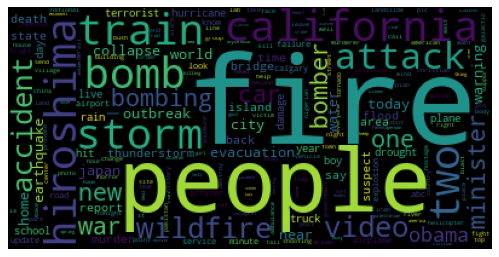

In [79]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

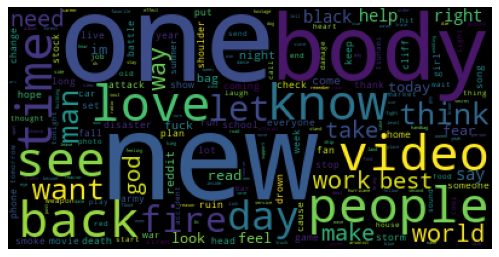

In [80]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [11]:
text = tweet['text']
y = tweet['target']

In [82]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [83]:
X.shape

(7613, 22545)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [85]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [12]:
from sklearn.svm import LinearSVC

In [87]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Classification with `Word2Vec` and SVM


In [13]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [14]:
import spacy
import en_core_web_lg

In [15]:
nlp = en_core_web_lg.load()

In [93]:
x = 'cat dog'
doc = nlp(x)

In [108]:
doc.vector.shape

(300,)

In [16]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [17]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [110]:
tweet.head()

id  ...                                                vec
0   1  ...  [-0.26623327, 0.05843069, -0.1404636, -0.05265...
1   4  ...  [-0.014817425, -0.09212343, -0.10716944, -0.33...
2   5  ...  [0.0059339865, 0.016337818, -0.105279535, -0.0...
3   6  ...  [-0.13400537, 0.25267026, 0.09032763, -0.16645...
4   7  ...  [-0.06394094, -0.01423019, 0.0063574947, 0.071...

[5 rows x 14 columns]

In [18]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [112]:
X.shape

(7613, 1)

In [115]:
X[0][0].shape

(300,)

In [19]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [117]:
X.shape

(7613, 300)

In [20]:
y = tweet['target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [22]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)

NameError: ignored

## Word Embeddings and Classification with Deep Learning


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [95]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [122]:
token = Tokenizer()
token.fit_on_texts(text)

In [123]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [124]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [125]:
encoded_text = token.texts_to_sequences(text)

In [126]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [127]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [128]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [104]:
X.shape

(7613, 40)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [130]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       869
           1       0.46      0.47      0.47       654

    accuracy                           0.54      1523
   macro avg       0.53      0.53      0.53      1523
weighted avg       0.54      0.54      0.54      1523

CPU times: user 605 ms, sys: 6.98 ms, total: 612 ms
Wall time: 606 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [131]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [132]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2258100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [133]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 21s 29ms/step - loss: 0.6661 - accuracy: 0.5745 - val_loss: 0.6383 - val_accuracy: 0.6815
Epoch 2/5
191/191 [==============================] - 5s 26ms/step - loss: 0.5372 - accuracy: 0.7544 - val_loss: 0.5115 - val_accuracy: 0.7584
Epoch 3/5
191/191 [==============================] - 5s 26ms/step - loss: 0.3677 - accuracy: 0.8470 - val_loss: 0.4859 - val_accuracy: 0.7682
Epoch 4/5
191/191 [==============================] - 5s 26ms/step - loss: 0.2479 - accuracy: 0.9080 - val_loss: 0.5071 - val_accuracy: 0.7649
Epoch 5/5
191/191 [==============================] - 5s 26ms/step - loss: 0.1505 - accuracy: 0.9461 - val_loss: 0.5559 - val_accuracy: 0.7544
CPU times: user 41.4 s, sys: 2.66 s, total: 44.1 s
Wall time: 41.6 s


In [135]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [136]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [137]:
vec

array([[  7,  31,   5, 103,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [138]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [139]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 182kB/s 
     |████████████████████████████████| 6.8MB 43.8MB/s 
     |████████████████████████████████| 983kB 48.3MB/s 
     |████████████████████████████████| 266kB 42.9MB/s 
     |████████████████████████████████| 1.9MB 19.9MB/s 
     |████████████████████████████████| 1.2MB 46.7MB/s 
     |████████████████████████████████| 471kB 35.2MB/s 
     |████████████████████████████████| 901kB 41.9MB/s 
     |████████████████████████████████| 3.3MB 42.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.3-cp37-none-any.whl size=25282390 sha256=e85085b4c639fac1018f88dec0398e3ede8aace1f85a78b03b0f2037f7d3b952
  Stored in directory: /root/.cache/pip/wheels/16/05/be/d6e659b3349016b1059e19fa028f165af4eeae2c196f329112
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=4f69db18a395bcf70dc53d447207abf509f1c119ca5773b283f5e5cfeb3845a3
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7d

In [37]:
tweet.head(5)

id  ...                                                vec
0   1  ...  [-0.26623327, 0.05843069, -0.1404636, -0.05265...
1   4  ...  [-0.014817425, -0.09212343, -0.10716944, -0.33...
2   5  ...  [0.0059339865, 0.016337818, -0.105279535, -0.0...
3   6  ...  [-0.13400537, 0.25267026, 0.09032763, -0.16645...
4   7  ...  [-0.06394094, -0.01423019, 0.0063574947, 0.071...

[5 rows x 14 columns]

In [26]:
import ktrain
from ktrain import text

In [27]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
5365         1.0     0.0
5913         1.0     0.0
6536         1.0     0.0
2623         1.0     0.0
5421         1.0     0.0
['not_target', 'target']
      not_target  target
3581         1.0     0.0
4778         1.0     0.0
3655         1.0     0.0
5767         0.0     1.0
5927         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [28]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [29]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [30]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 68s 447ms/step - loss: 0.4971 - accuracy: 0.7573 - val_loss: 0.3933 - val_accuracy: 0.8425


In [31]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 43s 403ms/step - loss: 0.3597 - accuracy: 0.8507 - val_loss: 0.3827 - val_accuracy: 0.8491
Epoch 2/3
108/108 [==============================] - 44s 404ms/step - loss: 0.3313 - accuracy: 0.8641 - val_loss: 0.3794 - val_accuracy: 0.8517
Epoch 3/3
108/108 [==============================] - 44s 405ms/step - loss: 0.2455 - accuracy: 0.9083 - val_loss: 0.4355 - val_accuracy: 0.8333


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 133s 1s/step - loss: 0.3352 - accuracy: 0.8590 - val_loss: 0.4615 - val_accuracy: 0.8228
Epoch 2/3
108/108 [==============================] - 133s 1s/step - loss: 0.3115 - accuracy: 0.8748 - val_loss: 0.5920 - val_accuracy: 0.7480
Epoch 3/3
108/108 [==============================] - 133s 1s/step - loss: 0.1731 - accuracy: 0.9365 - val_loss: 0.5802 - val_accuracy: 0.8346


In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [38]:
data = ['i met you today by accident', 'There was a earth quake in LA']

In [39]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:215: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  warnings.warn('List or array of two texts supplied, so task being treated as text classification. ' +\


array([[0.9262733 , 0.07372674],
       [0.01347372, 0.9865263 ]], dtype=float32)

In [40]:
predictor.predict(data[1])

'target'

In [42]:
classes = predictor.get_classes()
classes

['not_target', 'target']

In [43]:
data

['i met you today by accident', 'There was a earth quake in LA']

In [44]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [45]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)